In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import threading
import multiprocessing
import time
from IPython.display import clear_output
from message_service import MessageProcessor
from movies_pb2 import ConsumedMessage, PublishedMessage

import setup

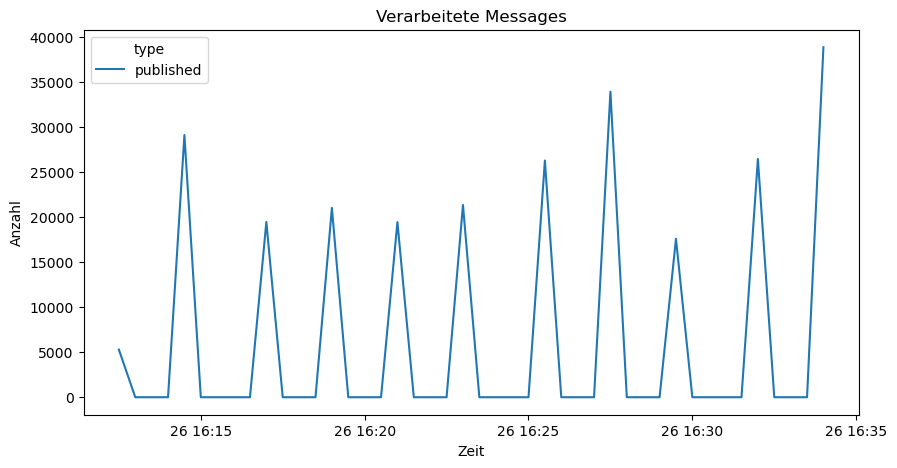

                   timestamp       type        n
0  2022-10-26 16:12:30+00:00  published   5288.0
1  2022-10-26 16:13:00+00:00  published      0.0
2  2022-10-26 16:13:30+00:00  published      0.0
3  2022-10-26 16:14:00+00:00  published      0.0
4  2022-10-26 16:14:30+00:00  published  29130.0
5  2022-10-26 16:15:00+00:00  published      0.0
6  2022-10-26 16:15:30+00:00  published      0.0
7  2022-10-26 16:16:00+00:00  published      0.0
8  2022-10-26 16:16:30+00:00  published      0.0
9  2022-10-26 16:17:00+00:00  published  19469.0
10 2022-10-26 16:17:30+00:00  published      0.0
11 2022-10-26 16:18:00+00:00  published      0.0
12 2022-10-26 16:18:30+00:00  published      0.0
13 2022-10-26 16:19:00+00:00  published  21035.0
14 2022-10-26 16:19:30+00:00  published      0.0
15 2022-10-26 16:20:00+00:00  published      0.0
16 2022-10-26 16:20:30+00:00  published      0.0
17 2022-10-26 16:21:00+00:00  published  19459.0
18 2022-10-26 16:21:30+00:00  published      0.0
19 2022-10-26 16:22:

KeyboardInterrupt: 

In [2]:
class PerformanceMessageProcessor(MessageProcessor):
	def __init__(self, topics, lock):
		super().__init__(
			'performance_message_processor', 
			lambda t: PublishedMessage() if t == 'published-messages' else ConsumedMessage(), 
			topics,
			publish_metrics=False
		)
		self.new_data = []
		self.lock = lock # mutex for self.new_data

	def on_message(self, message, topic):
		type = 'published' if topic == 'published-messages' else 'consumed'
		client = message.publisher if topic == 'published-messages' else message.consumer

		data = pd.Series({
			'type': type, 
			'client': client, 
			'timestamp': pd.to_datetime(message.timestamp, unit='s', utc=True), 
			'hostname': message.hostname
		})

		self.lock.acquire()
		self.new_data.append(data)
		self.lock.release()

		# if len(self.new_data) >= 5000:
		# 	self.__plot()
		

lock = multiprocessing.Lock()
processor = PerformanceMessageProcessor(['published-messages', 'consumed-messages'], lock)
messaging_thread = threading.Thread(target=processor.run)
messaging_thread.start()

freq = '30s'
data = None
while True:
	try:
		time.sleep(10)

		lock.acquire()
		new_data = processor.new_data.copy()
		processor.new_data = []
		lock.release()

		if len(new_data) == 0:
			print('no new data')
			continue

		clear_output(wait=True)
		plt.figure(figsize = (10, 5))

		new_data = pd.DataFrame(new_data)
		new_data = new_data.set_index('timestamp')
		new_data = new_data.groupby([pd.Grouper(freq=freq), 'type']).size()
		new_data = new_data.rename('n')
		new_data = new_data.reset_index()

		new_data = new_data if data is None else pd.concat([data, new_data])
		new_data = new_data.set_index('timestamp').groupby([pd.Grouper(freq=freq), 'type'])['n'].sum().reset_index().set_index('timestamp')

		data_list = []
		for type in new_data['type'].unique():
			per_type = new_data[new_data['type'] == type].asfreq(freq)
			per_type['type'] = type
			data_list.append(per_type)

		data = pd.concat(data_list).fillna(0).reset_index()

		sns.lineplot(data=data, x='timestamp', y='n', hue='type')
		plt.title('Verarbeitete Messages')
		plt.xlabel('Zeit')
		plt.ylabel('Anzahl')
		plt.show()

		print(data)
	except Exception as ex:
		print(ex)
		break


print('stopping messaging thread')
messaging_thread.stop()
messaging_thread.join()
